In [17]:
# Import the matplotlib library and alias it as plt for convenience
import matplotlib.pyplot as plt

# Import the numpy library and alias it as np for convenience
import numpy as np

# Import the PyTorch library, which is a popular deep learning framework
import torch

# Import the neural network module from PyTorch
import torch.nn as nn

# Import the functional module from PyTorch for common operations
import torch.nn.functional as F

# Import the optimization module from PyTorch for updating parameters during training
import torch.optim as optim

# Enable inline plotting for Jupyter notebooks or IPython environments
%matplotlib inline


## Global Settings

In [18]:
LEFT_CENTER = (3, 3)
RIGHT_CENTER = (3, -2)
# Coordinates for centering the gaussian data distribution 

## Defining the Model

In [19]:
# Define a Perceptron class that inherits from nn.Module (PyTorch base class for neural network modules)
class Perceptron(nn.Module):
    """ A Perceptron is one Linear layer """

    # Constructor method (__init__) for initializing the Perceptron
    def __init__(self, input_dim):
        """
        Args:
            input_dim (int): size of the input features
        """
        # Call the constructor of the parent class (nn.Module)
        super(Perceptron, self).__init__()

        # Define a linear layer with input_dim input features and 1 output feature. Auto initializes weights and biases
        self.fc1 = nn.Linear(input_dim, 1)

    # Forward method for defining the forward pass of the Perceptron
    def forward(self, x_in):
        """The forward pass of the MLP

        Args:
            x_in (torch.Tensor): an input data tensor.
                x_in.shape should be (batch, input_dim)
        Returns:
            the resulting tensor. tensor.shape should be (batch, 1)
        """
        # Apply the sigmoid activation function to the output of the linear layer
        return torch.sigmoid(self.fc1(x_in))


## Get Data Function

In [20]:
def get_toy_data(batch_size, left_center=LEFT_CENTER, right_center=RIGHT_CENTER):
    x_data = [] # List to store input data points
    y_targets = np.zeros(batch_size) # Numpy array to store corresponding binary labels (0 or 1)
    for batch_i in range(batch_size):
        # Randomly decide whether to sample from the left or right center
        if np.random.random() > 0.5:
            x_data.append(np.random.normal(loc=left_center))
        else:
            x_data.append(np.random.normal(loc=right_center))
            y_targets[batch_i] = 1 # Set label to 1 for points sampled from the right center
             
    # Convert the lists to PyTorch tensors and specify the data type as float32
    return torch.tensor(x_data, dtype=torch.float32), torch.tensor(y_targets, dtype=torch.float32)

## Visualizing Results Function

In [21]:
def visualize_results(perceptron, x_data, y_truth, n_samples=1000, ax=None, epoch=None, 
                      title='', levels=[0.3, 0.4, 0.5], linestyles=['--', '-', '--']):
    # Make predictions using the perceptron model
    y_pred = perceptron(x_data)
    # Convert predictions to binary (0 or 1) based on a threshold of 0.5
    y_pred = (y_pred > 0.5).long().data.numpy().astype(np.int32)

    # Convert input data and ground truth labels to numpy arrays
    x_data = x_data.data.numpy()
    y_truth = y_truth.data.numpy().astype(np.int32)

    # Number of classes (binary classification, so n_classes = 2)
    n_classes = 2

    # Initialize empty lists to store data for each class
    all_x = [[] for _ in range(n_classes)]
    all_colors = [[] for _ in range(n_classes)]
    
    # Colors and markers for plotting
    colors = ['black', 'white']
    markers = ['o', '*']
    
    # Populate lists for each class based on predictions and ground truth
    for x_i, y_pred_i, y_true_i in zip(x_data, y_pred, y_truth):
        all_x[y_true_i].append(x_i)
        if y_pred_i == y_true_i:
            all_colors[y_true_i].append("white")
        else:
            all_colors[y_true_i].append("black")

    # Convert the lists of data points for each class to numpy arrays
    all_x = [np.stack(x_list) for x_list in all_x]

    # If no axis is provided, create a new subplot
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(10, 10))
        
    # Plot the data points for each class with different markers and colors
    for x_list, color_list, marker in zip(all_x, all_colors, markers):
        ax.scatter(x_list[:, 0], x_list[:, 1], edgecolor="black", marker=marker, facecolor=color_list, s=300)
    
    # Set x-axis and y-axis limits based on the data points
    xlim = (min([x_list[:,0].min() for x_list in all_x]), 
            max([x_list[:,0].max() for x_list in all_x]))
    ylim = (min([x_list[:,1].min() for x_list in all_x]), 
            max([x_list[:,1].max() for x_list in all_x]))
            
    # Plot the decision boundary (hyperplane) using contour lines
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    
    Z = perceptron(torch.tensor(xy, dtype=torch.float32)).detach().numpy().reshape(XX.shape)
    ax.contour(XX, YY, Z, colors='k', levels=levels, linestyles=linestyles)    
    
    # Set the title of the plot
    plt.suptitle(title)
    
    # Display the current epoch if provided
    if epoch is not None:
        plt.text(xlim[0], ylim[1], "Epoch = {}".format(str(epoch)))

## Initial Data Plot

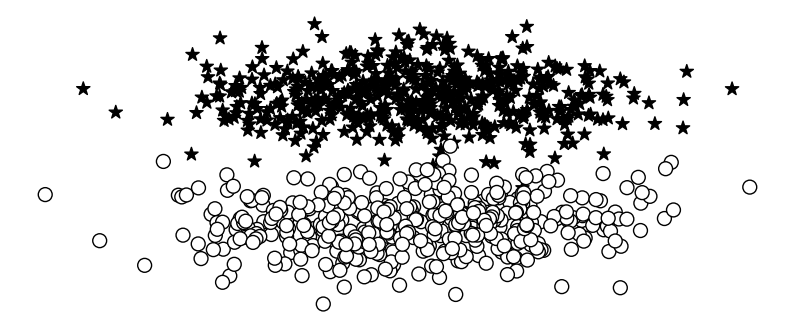

In [22]:
# Set a seed for reproducibility
seed = 1337

# Set the seed for the random number generators in PyTorch and NumPy
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

# Generate synthetic toy data using the function get_toy_data
x_data, y_truth = get_toy_data(batch_size=1000)

# Convert the PyTorch tensors to NumPy arrays
x_data = x_data.data.numpy()
y_truth = y_truth.data.numpy()

# Initialize empty lists to store data for each class
left_x = []
right_x = []
left_colors = []
right_colors = []

# Loop through the generated data and ground truth labels
for x_i, y_true_i in zip(x_data, y_truth):
    color = 'black'

    # Classify data points into left or right based on ground truth labels
    if y_true_i == 0:
        left_x.append(x_i)
        left_colors.append(color)
    else:
        right_x.append(x_i)
        right_colors.append(color)

# Convert the lists of data points for each class to numpy arrays
left_x = np.stack(left_x)
right_x = np.stack(right_x)

# Create a subplot for visualization
_, ax = plt.subplots(1, 1, figsize=(10, 4))

# Scatter plot for the left class with '*' marker and black color
ax.scatter(left_x[:, 0], left_x[:, 1], color=left_colors, marker='*', s=100)

# Scatter plot for the right class with 'o' marker, white face color, and black edge color
ax.scatter(right_x[:, 0], right_x[:, 1], facecolor='white', edgecolor=right_colors, marker='o', s=100)

# Turn off axis for cleaner visualization
plt.axis('off');


## The Training + intermittent data plots

Epoch 0: Number of misclassifications = 2491
Epoch 1: Number of misclassifications = 2442
Epoch 2: Number of misclassifications = 2432
Epoch 3: Number of misclassifications = 2272
Epoch 4: Number of misclassifications = 1911
Epoch 5: Number of misclassifications = 1299
Epoch 6: Number of misclassifications = 807
Epoch 7: Number of misclassifications = 414
Epoch 8: Number of misclassifications = 215
Epoch 9: Number of misclassifications = 126
Epoch 10: Number of misclassifications = 75
Epoch 11: Number of misclassifications = 46
Epoch 12: Number of misclassifications = 35
Epoch 13: Number of misclassifications = 36
Epoch 14: Number of misclassifications = 34
Epoch 15: Number of misclassifications = 41


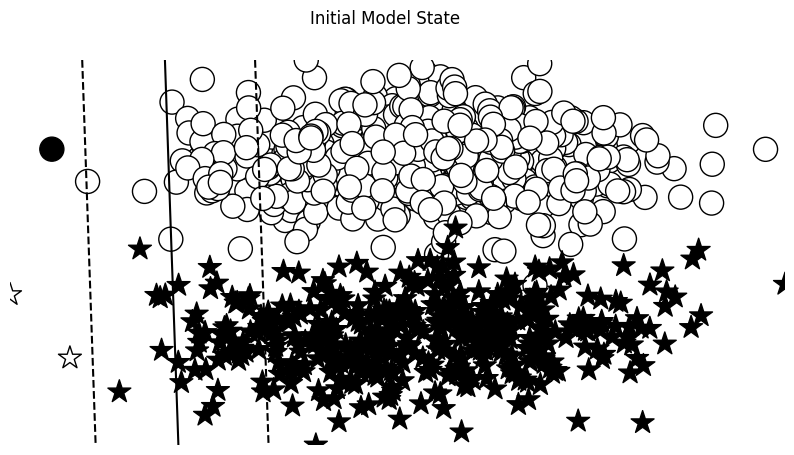

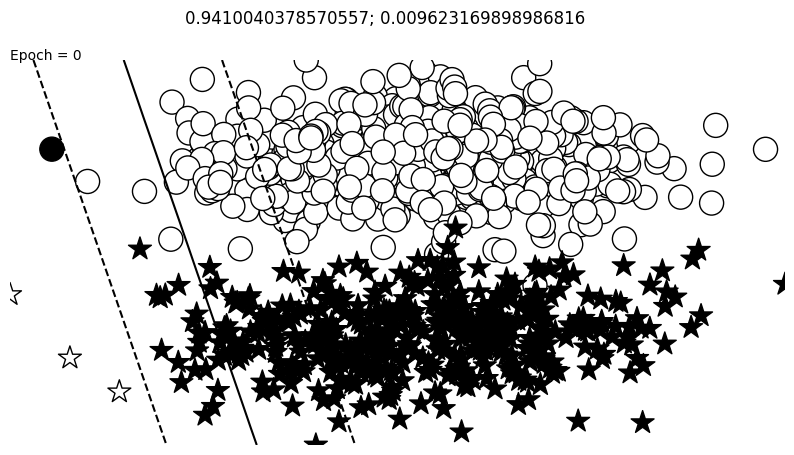

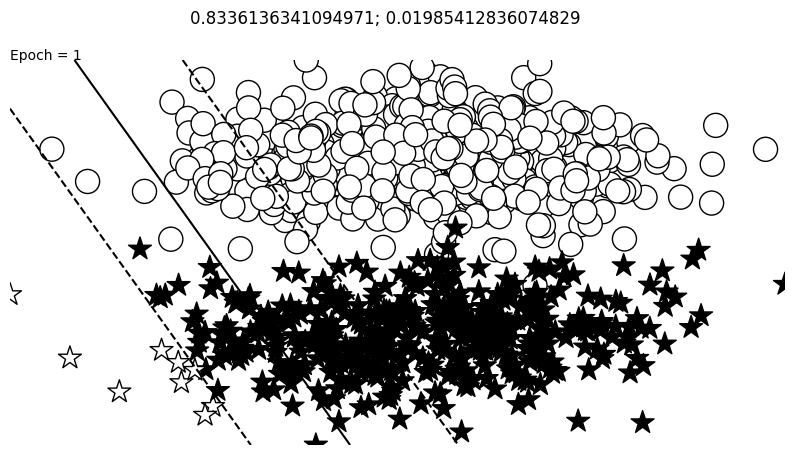

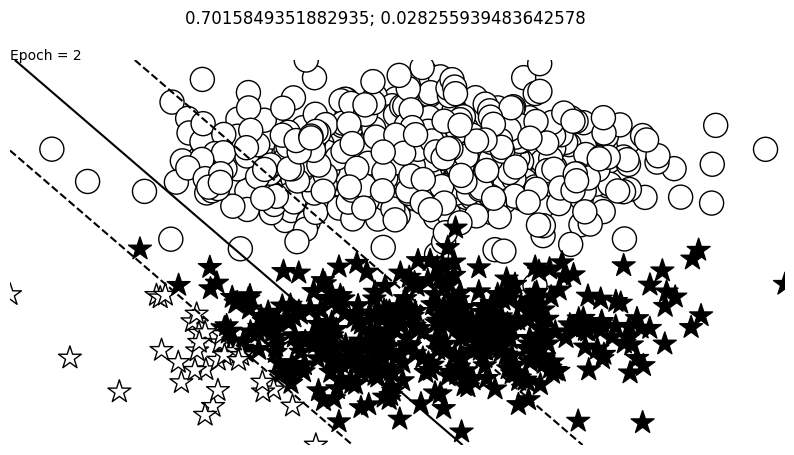

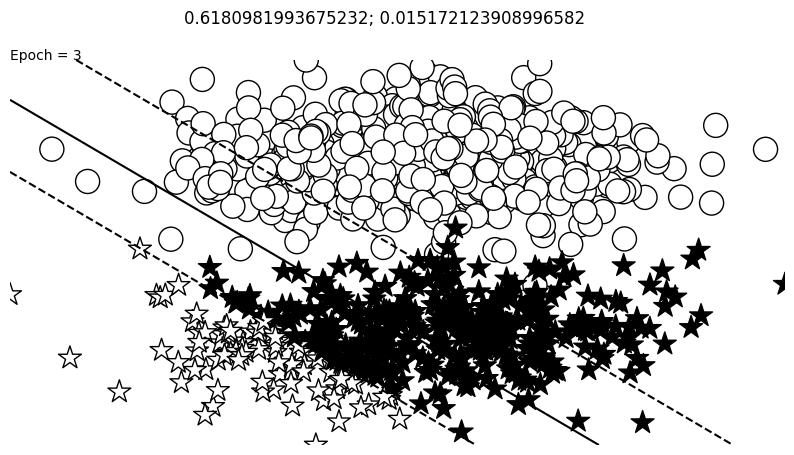

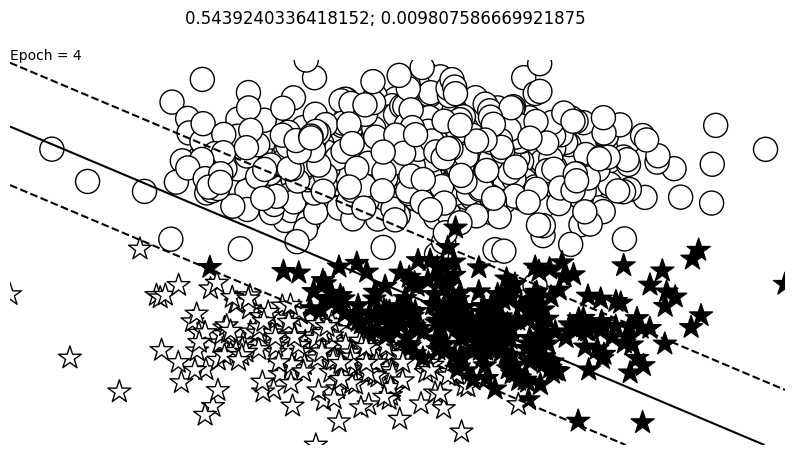

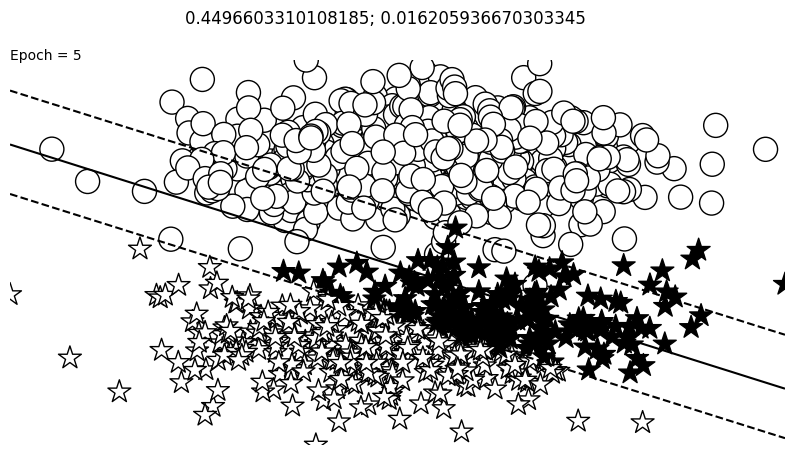

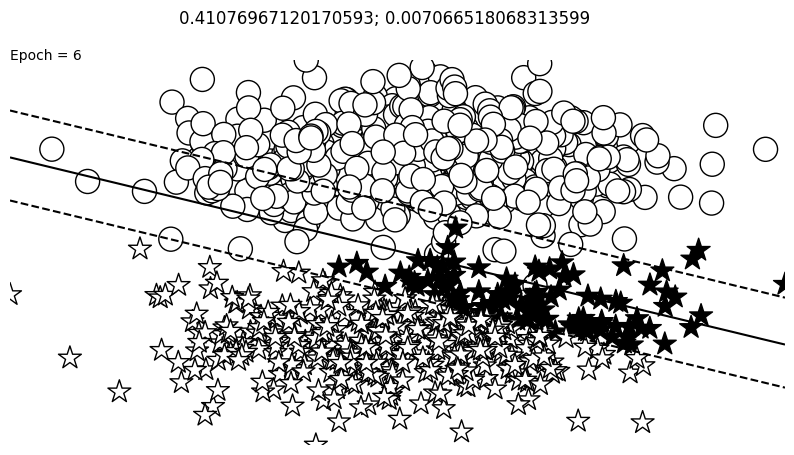

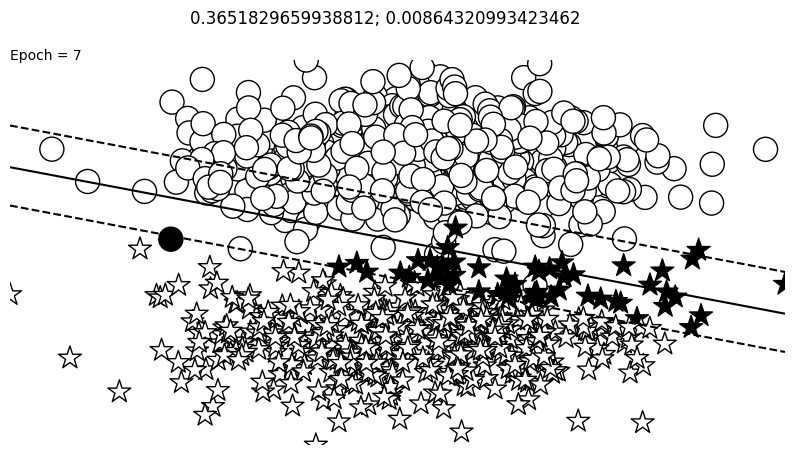

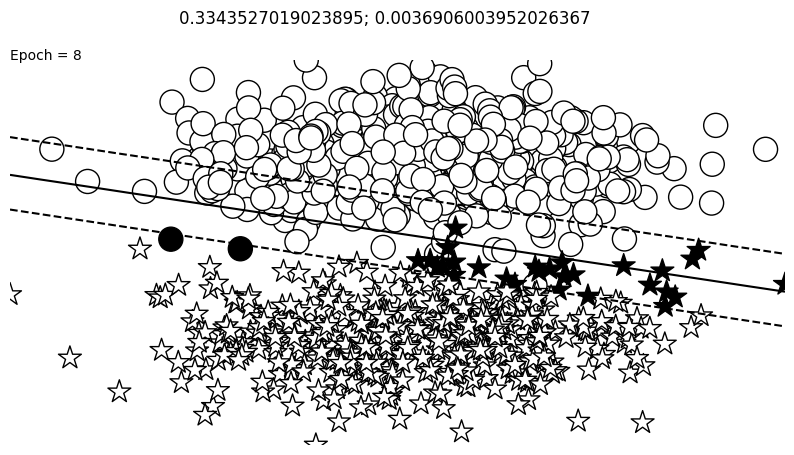

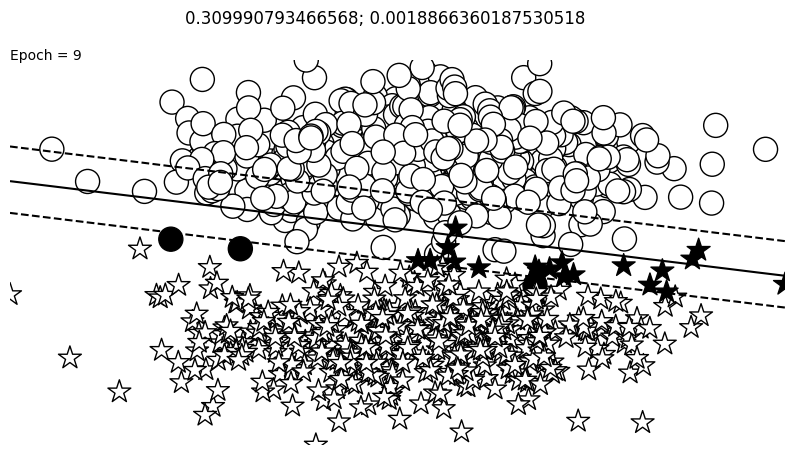

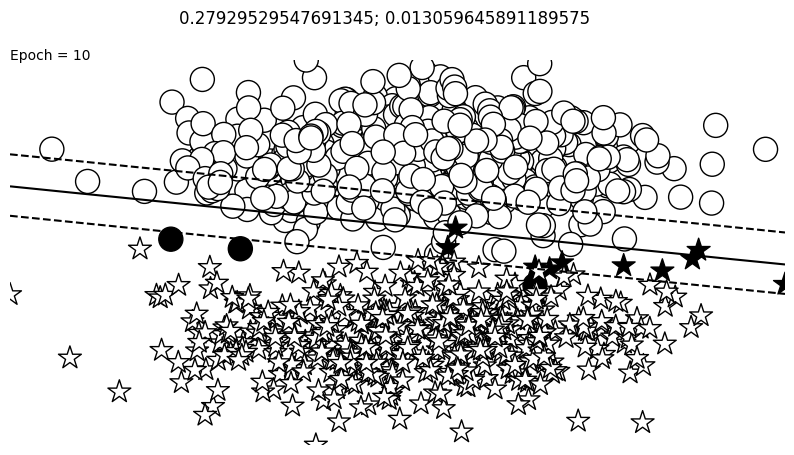

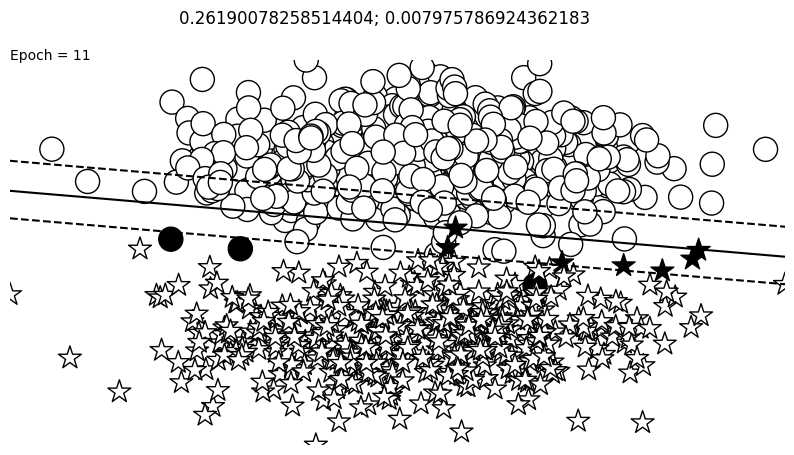

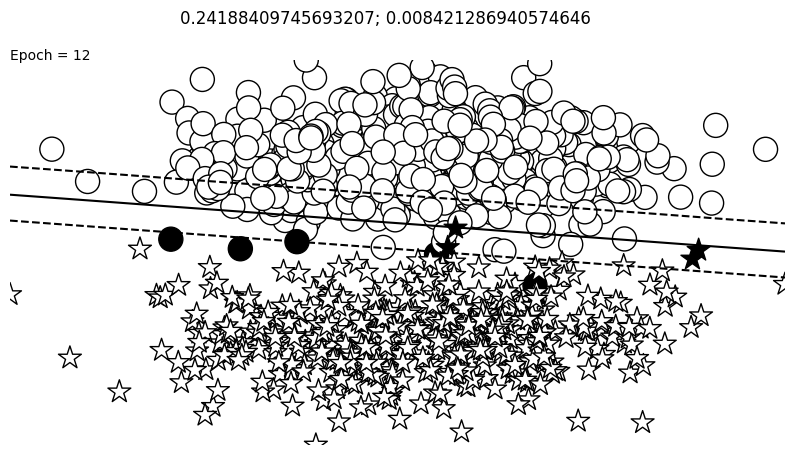

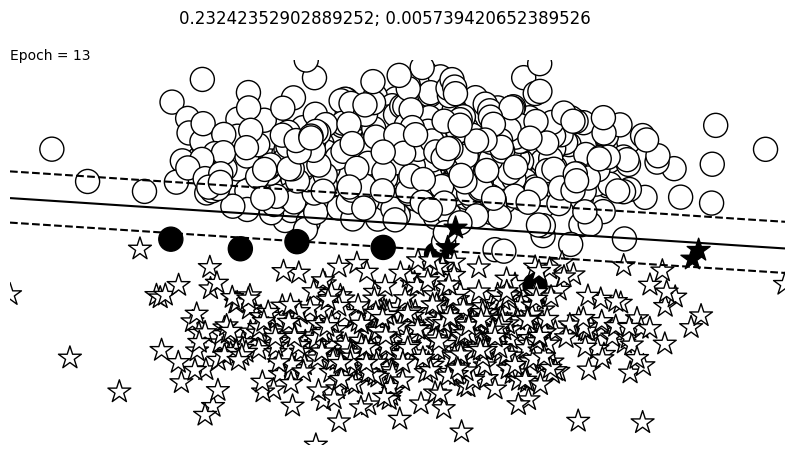

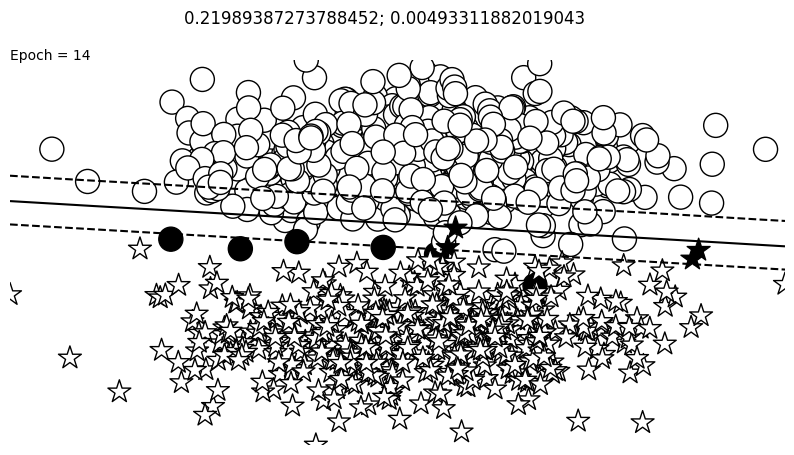

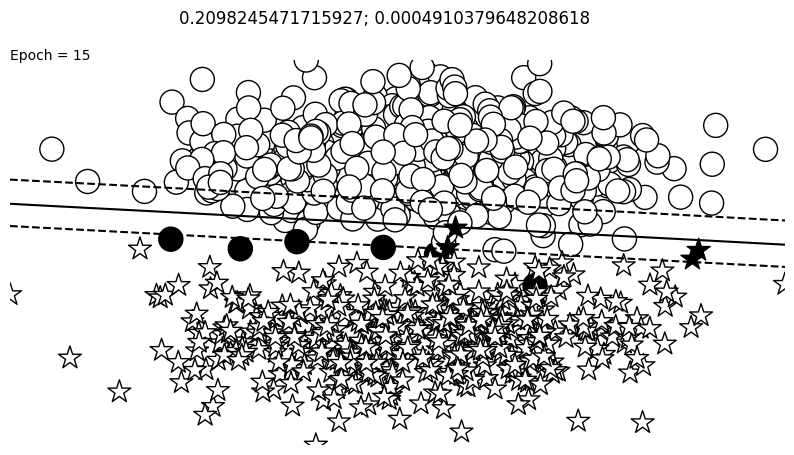

In [25]:
# Learning rate for the optimizer
lr = 0.01

# Dimensionality of the input features
input_dim = 2

# Batch size for training
batch_size = 1000

# Number of epochs for training
n_epochs = 12

# Number of batches for each epoch
n_batches = 5

# Set a seed for reproducibility
seed = 1337

# Set the seed for the random number generators in PyTorch and NumPy
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

# Create an instance of the Perceptron class with the specified input dimension
perceptron = Perceptron(input_dim=input_dim)

# Use the Adam optimizer for updating the perceptron's parameters
optimizer = optim.Adam(params=perceptron.parameters(), lr=lr)

# Binary Cross Entropy Loss function
bce_loss = nn.BCELoss()

# List to store the losses during training
losses = []

# Generate static toy data for visualization
x_data_static, y_truth_static = get_toy_data(batch_size)
# Create a subplot for visualizing the initial state of the model
fig, ax = plt.subplots(1, 1, figsize=(10,5))
visualize_results(perceptron, x_data_static, y_truth_static, ax=ax, title='Initial Model State')
plt.axis('off')
# Save the initial plot as an image (commented out)
# plt.savefig('initial.png')

# Parameters for controlling the training loop
change = 1.0
last = 10.0
epsilon = 1e-3
epoch = 0

# Training loop
while change > epsilon or epoch < n_epochs or last > 0.3:
     # List to store misclassified samples for each epoch
    misclassified_samples = []
    # Loop through batches
    for _ in range(n_batches):
        # Zero the gradients to avoid accumulating them
        optimizer.zero_grad()
        # Generate new toy data for each batch
        x_data, y_target = get_toy_data(batch_size)
        # Forward pass through the perceptron
        y_pred = perceptron(x_data).squeeze()
        # Compute the Binary Cross Entropy loss
        loss = bce_loss(y_pred, y_target)
        # Backward pass and optimization step
        loss.backward()
        optimizer.step()
        
        # Record the current loss value
        loss_value = loss.item()
        losses.append(loss_value)

        # Calculate the change in loss from the last iteration
        change = abs(last - loss_value)
        last = loss_value
        # Record the current misclassifications
        misclassified_samples.extend([(x, y_pred_i.item(), y_true_i.item()) 
                                      for x, y_pred_i, y_true_i in zip(x_data, y_pred, y_target) 
                                      if (y_pred_i > 0.5 and y_true_i == 0) or (y_pred_i <= 0.5 and y_true_i == 1)])
               
    # Create a subplot for visualizing the model state after each epoch
    fig, ax = plt.subplots(1, 1, figsize=(10,5))
    # Visualize the current state of the model
    visualize_results(perceptron, x_data_static, y_truth_static, ax=ax, epoch=epoch, 
                      title=f"{loss_value}; {change}")
    plt.axis('off')
    # Print the number of misclassifications for the current epoch
    num_misclassifications = len(misclassified_samples)
    print(f"Epoch {epoch}: Number of misclassifications = {num_misclassifications}")
    epoch += 1
    # plt.savefig('epoch{}_toylearning.png'.format(epoch))


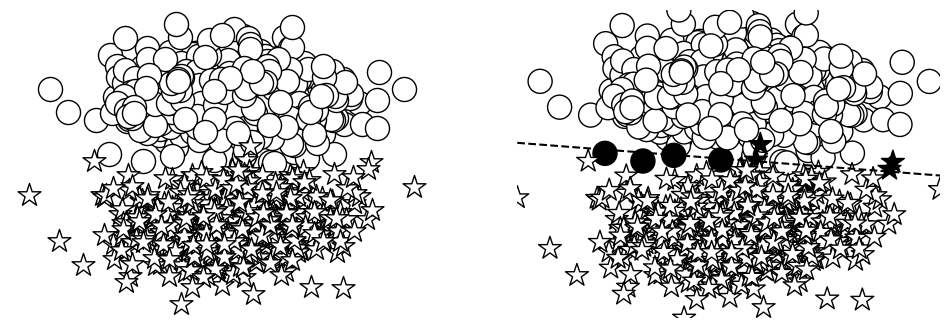

In [24]:
# Create a figure with 1 row and 2 columns of subplots, with a specified size
_, axes = plt.subplots(1, 2, figsize=(12, 4))

# Scatter plot for the left class with 'o' marker and black edge, white face, and size 300
axes[0].scatter(left_x[:, 0], left_x[:, 1], facecolor='white', edgecolor='black', marker='o', s=300)

# Scatter plot for the right class with '*' marker and black edge, white face, and size 300
axes[0].scatter(right_x[:, 0], right_x[:, 1], facecolor='white', edgecolor='black', marker='*', s=300)

# Turn off axis for the first subplot
axes[0].axis('off');

# Visualize the results of the perceptron on static toy data in the second subplot
visualize_results(perceptron, x_data_static, y_truth_static, epoch=None, levels=[0.5], ax=axes[1])

# Turn off axis for the second subplot
axes[1].axis('off');

# Save the figure as both a PNG and a PDF file
plt.savefig('perceptron_final.png')
plt.savefig('perceptron_final.pdf')
